In [65]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
import numpy as np
import torch.nn.functional as F
import librosa
import numpy as np
from torchvision import models
import os
import soundfile as sf
import librosa
import matplotlib.pyplot as plt

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [71]:
def audio_to_spectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512,duration=10):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr,duration=duration)
    
    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to magnitude spectrogram (absolute value)
    magnitude = np.abs(spectrogram)
    
    # Convert to log scale for better visualization
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)
    
    # Return the spectrogram as a PyTorch tensor
    return torch.tensor(log_magnitude, dtype= torch.float32).to(device), y, sr  # Return magnitude too

In [72]:
def plot_spectrogram(log_magnitude, sr, hop_length):
    # Create a matplotlib plot for the spectrogram
    plt.figure(figsize=(10, 6))
    
    # Display the log-magnitude spectrogram
    librosa.display.specshow(log_magnitude, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    
    # Add color bar and labels
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Scaled Spectrogram")
    plt.tight_layout()
    plt.show()

In [73]:
def spectrogram_to_audio(y):
    audio = np.abs(librosa.stft(y))
    y_inv = librosa.griffinlim(audio)
    return audio

In [74]:
log, y, sr = audio_to_spectrogram('kangaroo.wav')

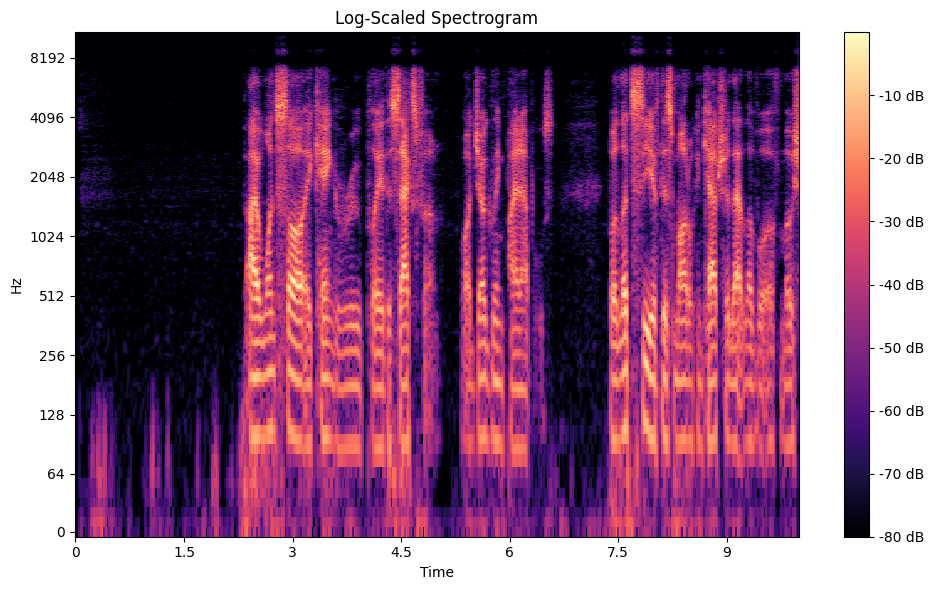

In [75]:
plot_spectrogram(log.cpu().numpy(), sr, hop_length=512)

In [76]:
def save_audio_as_wav(audio, sr=22050, filename='output.wav'):
    sf.write(filename, audio, sr)
    print("Audio Saved")

In [77]:
rev = spectrogram_to_audio(y)

In [79]:
save_audio_as_wav(y, sr=sr, filename='output.wav')

Audio Saved


In [80]:
def GramMatrix(input):
    # A = batch
    # B = Number of feature maps
    # C,D = Dimension of feature maps
    a,b,c,d = input.size()

    features = input.view(a*b,c*d)

    G = torch.mm(features, features.t())

    #Normalize by dividing by total
    return G.div(a*b*c*d)

In [81]:
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim, 128 * 16 * 16)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,kernel_size=3,stride=2),
            nn.Sigmoid(),
        )
    
    def encode(self,x):
        x = self.encoder(x)
        mean, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu).to(device)
        z = mu + logvar * eps
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [82]:
def loss_fn(recon,original,mu,logvar):
    recon_loss = F.mse_loss(recon,original,reduction='sum')
    kl_div = -0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return recon_loss,kl_div

In [84]:
model = VAE(latent_dim=64).to(device)

In [85]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)